<a href="https://colab.research.google.com/github/manjitullal/recommendation/blob/main/Content_%26_Collaborative_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%timeit

path = '/content/drive/MyDrive/datasets/movies/'

ratings = pd.read_csv(path + 'ratings_small.csv')
credits = pd.read_csv(path + 'credits.csv')
keywords = pd.read_csv(path + 'keywords.csv')
links = pd.read_csv(path + 'links.csv')
movie_metadata = pd.read_csv(path + 'movies_metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [ ]:
unique_users = len(ratings.userId.unique()) # unique users
average_user_ratings = ratings.groupby(by=['userId'])['movieId'].count() # average number of movies rated by a user 

print("Unique users", unique_users)
print("Average number of movies rated by the users", round(average_user_ratings.mean()))

Unique users 671
Average number of movies rated by the users 149


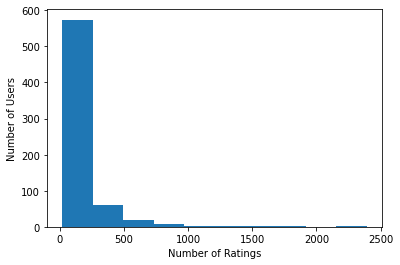

In [ ]:
import matplotlib.pyplot as plt
plt.hist(average_user_ratings)
plt.ylabel("Number of Users")
plt.xlabel("Number of Ratings")
plt.show()

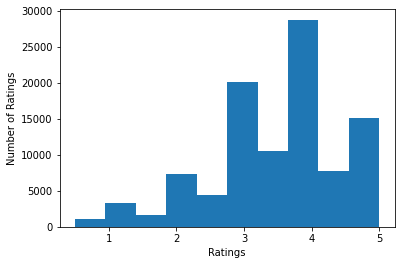

In [ ]:
plt.hist(ratings.rating)
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.show()

In [ ]:
credits.columns

Index(['cast', 'crew', 'id'], dtype='object')

In [ ]:
keywords.columns

Index(['id', 'keywords'], dtype='object')

In [ ]:
links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [ ]:
movie_metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [ ]:
movie_metadata_changed = movie_metadata.copy()
movie_metadata_changed.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [ ]:
movie_metadata_changed.drop(['belongs_to_collection', 'homepage', 'tagline'], axis=1, inplace=True)

In [ ]:
movie_metadata_changed.genres.head()

0    [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1    [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2    [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                       [{'id': 35, 'name': 'Comedy'}]
Name: genres, dtype: object

In [ ]:
%time

def genre(row):    
    import re 
    rows = row[1:-1]    
    matches = re.findall(r"\'name\'..\'\w+\'", rows)
    genre = ",".join([i.split(':')[1].replace("'","") for i in matches])    
    return genre

movie_metadata_changed['genres'] = movie_metadata_changed['genres'].apply(genre)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
movie_metadata_changed.genres.head()

0      Animation, Comedy, Family
1     Adventure, Fantasy, Family
2                Romance, Comedy
3         Comedy, Drama, Romance
4                         Comedy
Name: genres, dtype: object

In [ ]:
# handle a case where there is no id for the movie 

def change_type_id(x):
    try:
        return int(x)
    except ValueError:
        return None
    
movie_metadata_changed['id'] = movie_metadata_changed['id'].apply(change_type_id)

In [ ]:
movie_data_merge = movie_metadata_changed.merge(credits, on='id')

find a new feature called , weighted rating for a movie 

W_r = (v/(v+m)*R + (m/(v+m)*C

R is the mean rating
C is the mean vote for the movies
v is the number of votes for the movie 
m is the minimum number of votes to be needed to be in the top chart 

In [ ]:
%timeit 

m = movie_data_merge.vote_count.quantile(0.9)
C = movie_data_merge.vote_average.mean()
R = movie_data_merge['vote_average']    
v = movie_data_merge['vote_count']       
'''
def weighted_rating(row, m=m, C=C):
    R = movie_data_merge['vote_average']    
    v = movie_data_merge['vote_count']       
    
    return (v/(v+m)*R) + (m/(v+m)*C)                      
'''
movie_data_merge['score'] = (v/(v+m)*R) + (m/(v+m)*C)

In [ ]:
%timeit

movie_data_merge = movie_data_merge.sort_values(by='score',ascending=False)
movie_data_merge[['title', 'vote_count', 'vote_average', 'score']].head()

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.445870
837,The Godfather,6024.0,8.5,8.425439
10345,Dilwale Dulhania Le Jayenge,661.0,9.1,8.421458
12525,The Dark Knight,12269.0,8.3,8.265477
2854,Fight Club,9678.0,8.3,8.256385


In [ ]:
movie_data_merge.columns

Index(['adult', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'score'],
      dtype='object')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn import preprocessing

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
movie_data_merge['overview'] = movie_data_merge['overview'].fillna('')
tfidf_matrix = tfidf.fit_transform(movie_data_merge['overview'])

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer_matrix = vectorizer.fit_transform(movie_data_merge['overview'])

In [ ]:
#run only one method at a time due to memory requirement 
#cosine_sim1 = np.dot(preprocessing.normalize(vectorizer_matrix, axis=1), preprocessing.normalize(vectorizer_matrix, axis=1).T)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [ ]:
%time
cosine_sim2 = np.dot(preprocessing.normalize(tfidf_matrix, axis=1), preprocessing.normalize(tfidf_matrix, axis=1).T)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [ ]:
indices = pd.Series(movie_data_merge.index, index=movie_data_merge['title']).drop_duplicates()

In [ ]:
def content_recommendation(title, cosine_similarity, indices):
    index = indices[title]
    cosine_similarity_title = cosine_similarity[index].toarray().tolist()[0]
    temp = cosine_similarity[index].toarray().tolist()[0]
    temp.sort(reverse=True)
    temp = temp[1:11]
    movie_indices = [cosine_similarity_title.index(i) for i in temp]
    return movie_data_merge['title'].iloc[movie_indices]

In [ ]:
recommedation = content_recommendation('Up', cosine_sim2, indices)
recommedation.head(10)

8550     Man of a Thousand Faces
24891            Dead Man's Eyes
32073               The Deceased
22332     I Heart Monster Movies
4316                     Popcorn
23475                  Afflicted
34736          The Second Circle
9543            A Scanner Darkly
17987               The Presence
35298          World of Tomorrow
Name: title, dtype: object

In [ ]:
import tensorflow as tf

indices = ratings[['userId', 'movieId']].values
values = ratings['rating'].values

tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[unique_users, movie_data_merge.shape[0]])